## Image Captioning 
#### Prediction for Captions

In [1]:
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.applications.inception_v3 import preprocess_input
import numpy as np
from keras import backend as K
import tensorflow as tf
from keras.preprocessing import sequence

Using TensorFlow backend.


In [2]:
wordtoix = np.load('wordtoix.npy').item()
ixtoword = np.load('ixtoword.npy').item()
# Load your Saved Model
model = load_model('model_.h5')
max_length=34

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [3]:
# extract features from each photo in the directory
def extract_features(filename):
    model = InceptionV3(weights='imagenet')
    model = Model(model.input, model.layers[-2].output)
    image = load_img(filename, target_size=(299, 299))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
	# reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the Inception model
    image = preprocess_input(image)
	# get features
    feature = model.predict(image, verbose=0)
    return feature

In [4]:
def caption(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

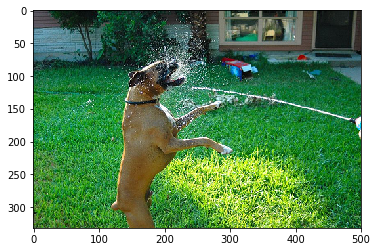

dog is middle head in the grass


In [5]:
pic = ('dog.jpg')
x=plt.imread(pic)
plt.imshow(x)
plt.show()
encoded = extract_features(pic)
print(caption(encoded))

In [ ]:
def beam_search_predictions(photo, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')       
          
            preds = model.predict([photo, par_caps],verbose=0)
         
            # Getting the top <beam_index>(n) predictions
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # creating a new list so as to put them via the model again
            for w in word_preds:
                
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption